<a href="https://colab.research.google.com/github/RichmondCap/trend-following/blob/main/20_50_SMA.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [ ]:
!pip install pandas numpy yfinance pyfolio-reloaded matplotlib
# Importing necessary libraries
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import yfinance as yf
import pyfolio as pf
import datetime as dt
import pandas_datareader.data as web
import os
import warnings
from IPython.display import display

In [19]:
# Ignore printing all warnings
warnings.filterwarnings('ignore')

# downloading historical data
_start = dt.date(2000,1,2)
_end = dt.date(2021,12,30)
SPY_df = yf.download('SPY', start = _start, end = _end)
XLE_df = yf.download('XLE', start = _start, end = _end)
XLK_df = yf.download('XLK', start = _start, end = _end)

# buy and hold returns calc
SPY_df['bnh_returns'] = np.log(SPY_df['Adj Close']/SPY_df['Adj Close'].shift(1))
XLE_df['bnh_returns'] = np.log(XLE_df['Adj Close']/XLE_df['Adj Close'].shift(1))
XLK_df['bnh_returns'] = np.log(XLK_df['Adj Close']/XLK_df['Adj Close'].shift(1))

[*********************100%%**********************]  1 of 1 completed
[*********************100%%**********************]  1 of 1 completed
[*********************100%%**********************]  1 of 1 completed


In [23]:
# Creating 20-day SMA columns for each dataframe
SPY_df['20_SMA'] = SPY_df['Adj Close'].rolling(window=20).mean()
XLE_df['20_SMA'] = XLE_df['Adj Close'].rolling(window=20).mean()
XLK_df['20_SMA'] = XLK_df['Adj Close'].rolling(window=20).mean()

# Creating 50-day SMA columns for each dataframe
SPY_df['50_SMA'] = SPY_df['Adj Close'].rolling(window=50).mean()
XLE_df['50_SMA'] = XLE_df['Adj Close'].rolling(window=50).mean()
XLK_df['50_SMA'] = XLK_df['Adj Close'].rolling(window=50).mean()

# Drop the first 50 Rows (used to calculate indicators only)
SPY_df.drop(SPY_df.head(50).index,inplace=True)

# Creating a signal column
SPY_df['Long'] = 0
XLE_df['Long'] = 0
XLK_df['Long'] = 0

SPY_df['Short'] = 0
XLE_df['Short'] = 0
XLK_df['Short'] = 0

# Buy signal for long positions
SPY_df['Long'] = (SPY_df['20_SMA'] > SPY_df['50_SMA']) & ~(SPY_df['20_SMA'].shift(1) > SPY_df['50_SMA'].shift(1))
SPY_df['Long'] = SPY_df['Long'].astype(int)

# Sell signal for short positions
SPY_df['Short'] = (SPY_df['20_SMA'] < SPY_df['50_SMA']) & ~(SPY_df['20_SMA'].shift(1) < SPY_df['50_SMA'].shift(1))
SPY_df['Short'] = SPY_df['Short'].astype(int) * -1

# Returns of the strategy
SPY_df['Strategy Returns'] = 0.0

# Calculate strategy returns
in_position = False
for i in range(1, len(SPY_df)):
    if SPY_df['Long'][i] == 1:
        SPY_df['Strategy Returns'][i] = SPY_df['bnh_returns'][i]
        in_position = True
    elif SPY_df['Short'][i] == -1:
        SPY_df['Strategy Returns'][i] = SPY_df['bnh_returns'][i] * -1
        in_position = False
    elif in_position:
        SPY_df['Strategy Returns'][i] = SPY_df['bnh_returns'][i]
    else:
        SPY_df['Strategy Returns'][i] = SPY_df['bnh_returns'][i] * -1

SPY Buy and Hold Returns: 1.6578134257047075
SPY Strategy Returns: 0.9070374585000819


Start date,2000-03-15
End date,2021-12-29
Total months,261
,Backtest
Annual return,2.275%
Cumulative returns,63.157%
Annual volatility,19.571%
Sharpe ratio,0.21
Calmar ratio,0.06
Stability,0.67
Max drawdown,-37.248%


Worst drawdown periods,Net drawdown in %,Peak date,Valley date,Recovery date,Duration
0,37.25,2008-11-20,2011-11-25,2018-12-19,2630
1,36.24,2002-07-23,2003-03-21,2008-10-09,1623
2,31.02,2000-03-15,2001-06-18,2002-07-19,613
3,28.04,2020-03-23,2020-05-13,2021-04-08,274
4,21.86,2018-12-24,2019-10-02,2020-03-12,319


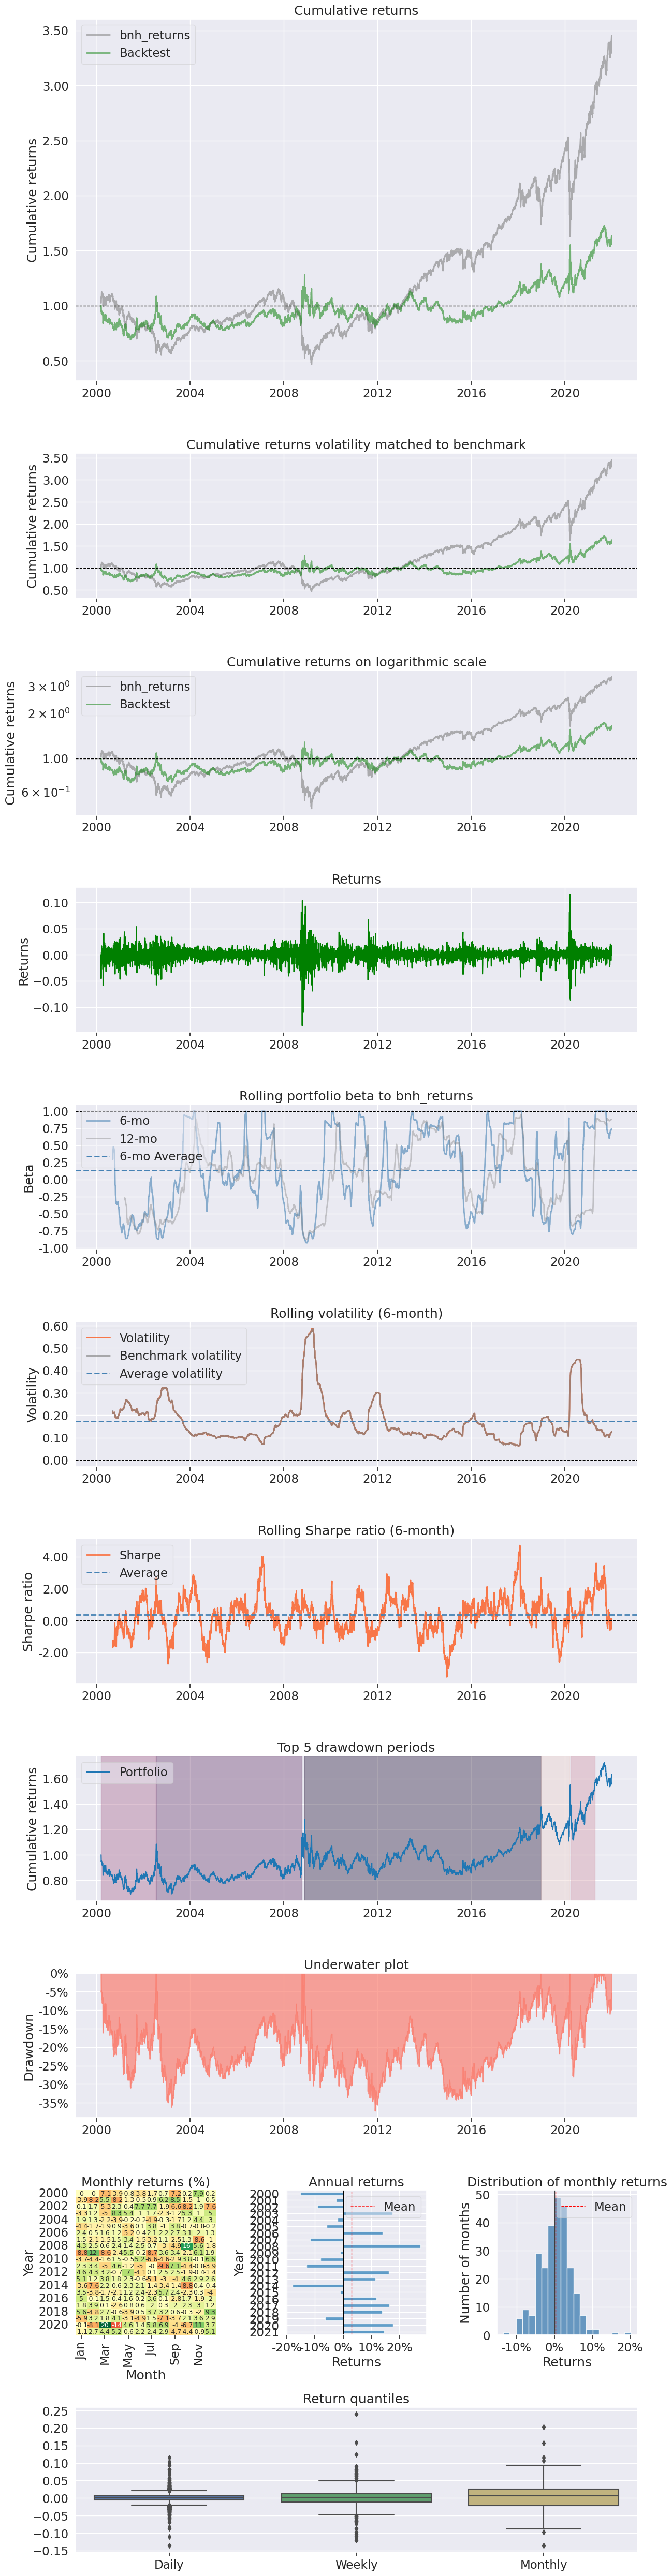

In [22]:
# Print out Returns
print("SPY Buy and Hold Returns:", SPY_df['bnh_returns'].sum())
print("SPY Strategy Returns:", SPY_df['Strategy Returns'].sum())

# Analysis
pf.create_returns_tear_sheet(SPY_df['Strategy Returns'], benchmark_rets = SPY_df['bnh_returns'])